In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.lines as lines
import matplotlib.gridspec as gridspec

from gofish import imagecube

from matplotlib.ticker import MultipleLocator, AutoMinorLocator, LinearLocator
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes, mark_inset

In [2]:
%matplotlib inline
%matplotlib notebook

In [3]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

In [4]:
def _calculate_flux_jy_sr(data,b_min,b_maj):
    """
    Convert brightness from Jy/beam to Jy/sr.
    ------------------------------------------------
    Parameters:
    b_maj, b_min: CLEAN beam (units: arcsec, arcsec)
    data:         intensity  (units: Jy/beam)
    ------------------------------------------------
    Return:
    data in Jy/sr
    """
    omega  = np.radians(b_min/3600.)
    omega *= np.radians(b_maj/3600.)
    
    beam_area = np.pi*omega/(4.*np.log(2.))
    
    return data/beam_area

In [5]:
def _jysr_to_tb(data,freq):
    """
    Convert data brightness from Jy/sr to K given the frequency in Hz using the RJ approximation.
    ------------------------------------------------------------------
    Parameters:
    data: intensity (units: Jy/sr)
    freq: frequency (units: Hz)
    ------------------------------------------------------------------
    Return:
    data in K
    """
    k_B   = 1.380649e-16  #erg/K
    c_vel = 2.99792458e10 #cm/s
    
    return data*1e-23*c_vel**2/(2*freq**2*k_B)

In [6]:
freq = np.array([3.38228441e11,2.29612176e11,9.75043346e10,3.30005835e10]) #Hz

In [7]:
disc_PA   = 11.28   #PA from Cathie's paper
disc_inc  = 49.24   #inclination from Cathie's paper
disc_dist = 160.318 #pc

In [8]:
interval    = np.linspace(-1.,3.,6)
cmap        = plt.get_cmap('magma') 
norm        = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap   = cm.ScalarMappable(norm=norm, cmap=cmap)
color_clean = scalarMap.to_rgba(interval[1])
color_vla   = scalarMap.to_rgba(interval[2])
color_frank = scalarMap.to_rgba(interval[3])

color_S2    = cm.Reds(np.linspace(0, 1, 32))
color_S1    = cm.Blues_r(np.linspace(0, 1, 32))
color_S1    = np.vstack([color_S1, np.ones((32, 4))])
color_sean  = np.vstack((color_S1, color_S2))
color_resid = colors.LinearSegmentedColormap.from_list('eddymap', color_sean)

Plot 2D maps and 2D profiles:

<IPython.core.display.Javascript object>


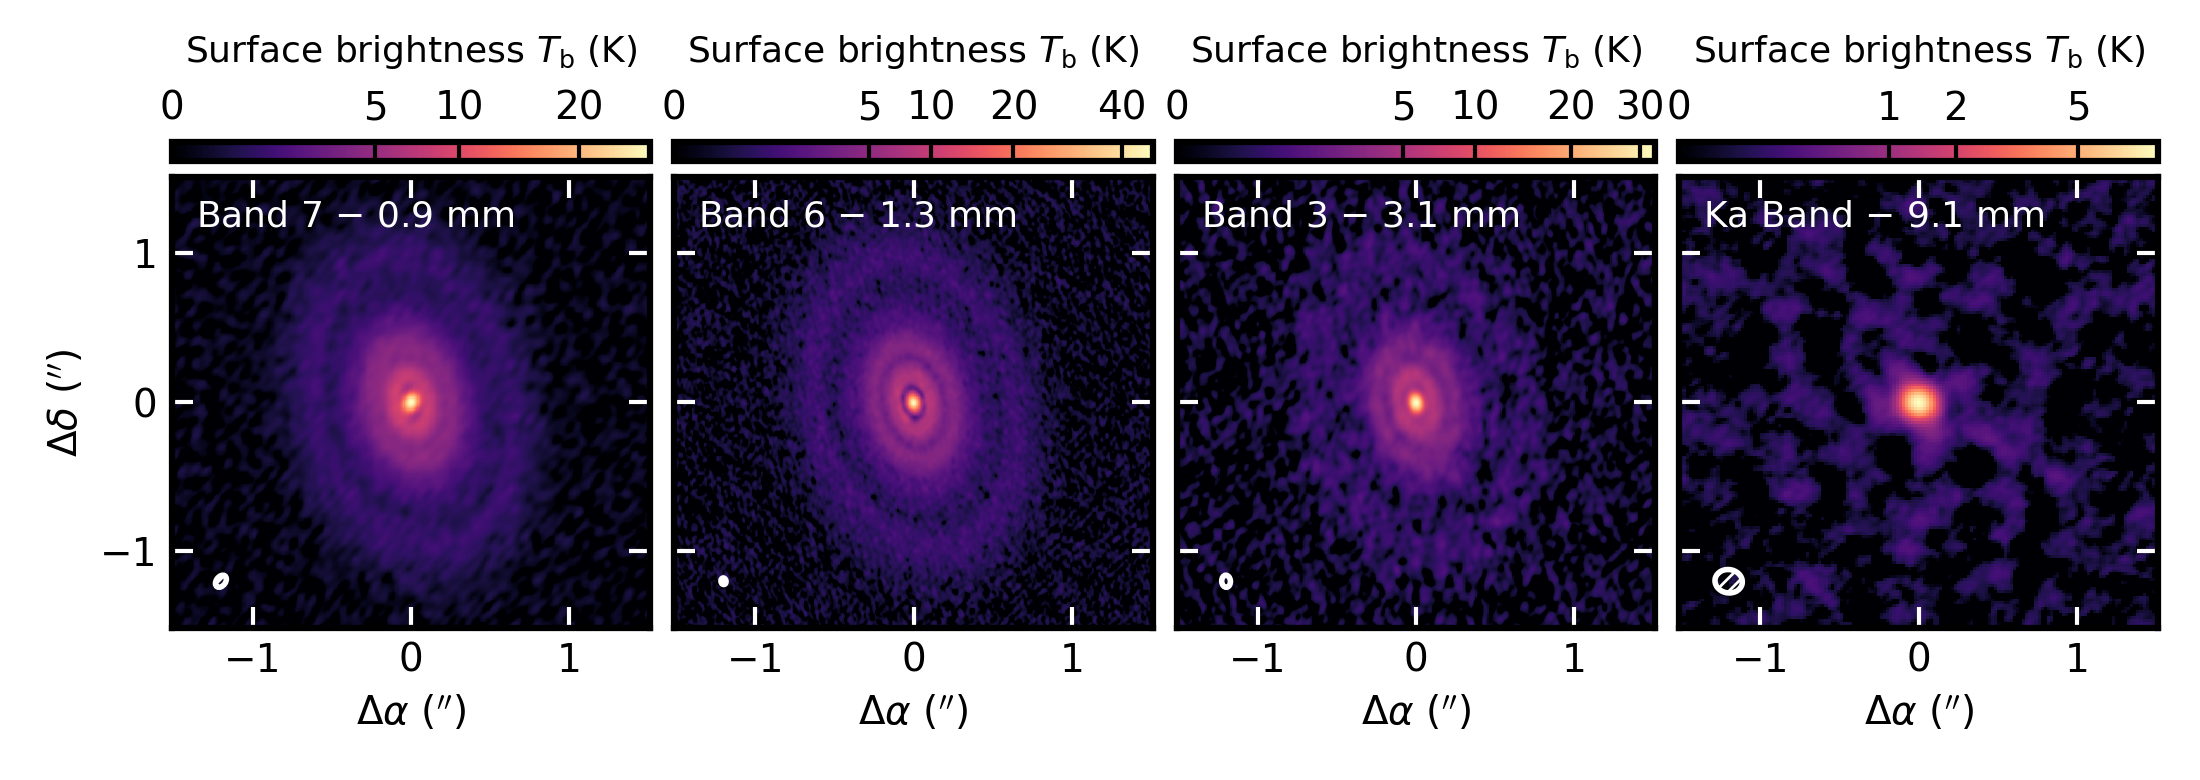

In [9]:
fitsfiles = [
    '../images_band7/CI_Tau_LB_-0.5robust_1.0sigma.image.tt0.fits',
    '../images_band6/CI_Tau_LB_0.5robust_1.0sigma.image.tt0.fits',
    '../images_band3/CI_Tau_LB_0.5robust_1.0sigma.image.tt0.fits',
    '../images_VLA/images_bandKa/CITau_VLA_Ka_Combined_ConfAB_selfcal_ave_1ch_60s_1.5robust_1.0sigma.image.tt0.fits',
]

lbl = [r'Band 7 $-$ 0.9 mm', r'Band 6 $-$ 1.3 mm', r'Band 3 $-$ 3.1 mm', r'Ka Band $-$ 9.1 mm']
pov = [0.5, 0.4, 0.4, 0.4]

ticks = {
    0:[0, 5, 10, 20],
    1:[0, 5, 10, 20, 40],
    2:[0, 5, 10, 20, 30],
    3:[0, 1, 2, 5],
}

pixels = [0.077/8.,0.032/8.,0.055/8.,0.156/8.]

fig, axs = plt.subplots(1,4,figsize=(11.,3.9),sharex='all',sharey='row')

for idx in range(len(fitsfiles)):
    cube = imagecube(fitsfiles[idx], FOV=3., pixel_scale=pixels[idx])

    data = cube.data
    data = cube.jybeam_to_Tb_RJ(data)

    cmap = plt.cm.get_cmap('magma').copy()
    norm = colors.PowerNorm(pov[idx], vmin=0., vmax=np.amax(data))

    if idx != 3:
        p = axs[idx].pcolormesh(cube.xaxis, -cube.yaxis, data, cmap=cmap, norm=norm)
    else:
        p = axs[idx].pcolormesh(-cube.xaxis, cube.yaxis, data, cmap=cmap, norm=norm)
    p.set_rasterized(True)
    axs[idx].xaxis.set_tick_params(color='white', which='both') 
    axs[idx].yaxis.set_tick_params(color='white', which='both') 

    el = patches.Ellipse(xy=(-1.2,-1.2), width=cube.bmin, height=cube.bmaj, angle=cube.bpa, color='white', fill=False, hatch='/////', lw=2)
    axs[idx].add_patch(el)

    bar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax = axs[idx], ticks=ticks[idx],
        orientation = 'horizontal', location = 'top',
        aspect = 25, pad = 0.03,
    )
    bar.ax.yaxis.set_tick_params(color='k', which='both') 
    bar.ax.xaxis.set_tick_params(color='k', which='both')
    bar.set_label(r'Surface brightness $T_{\rm b}$ (K)', labelpad=10, fontsize=13)
    bar.solids.set_rasterized(True)
    
    axs[idx].text(
        0.05, 0.95, r'{}'.format(lbl[idx]),   
        ha = 'left', va = 'top', transform = axs[idx].transAxes, 
        #bbox = dict(boxstyle="round", ec="w", fc="k"),
        color = 'white', fontsize = 13,
    )
    
    axs[idx].set_xlabel(r"$\Delta\alpha\ ('')$")

axs[0].set_ylabel(r"$\Delta\delta\ ('')$")

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig('maps_paper.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


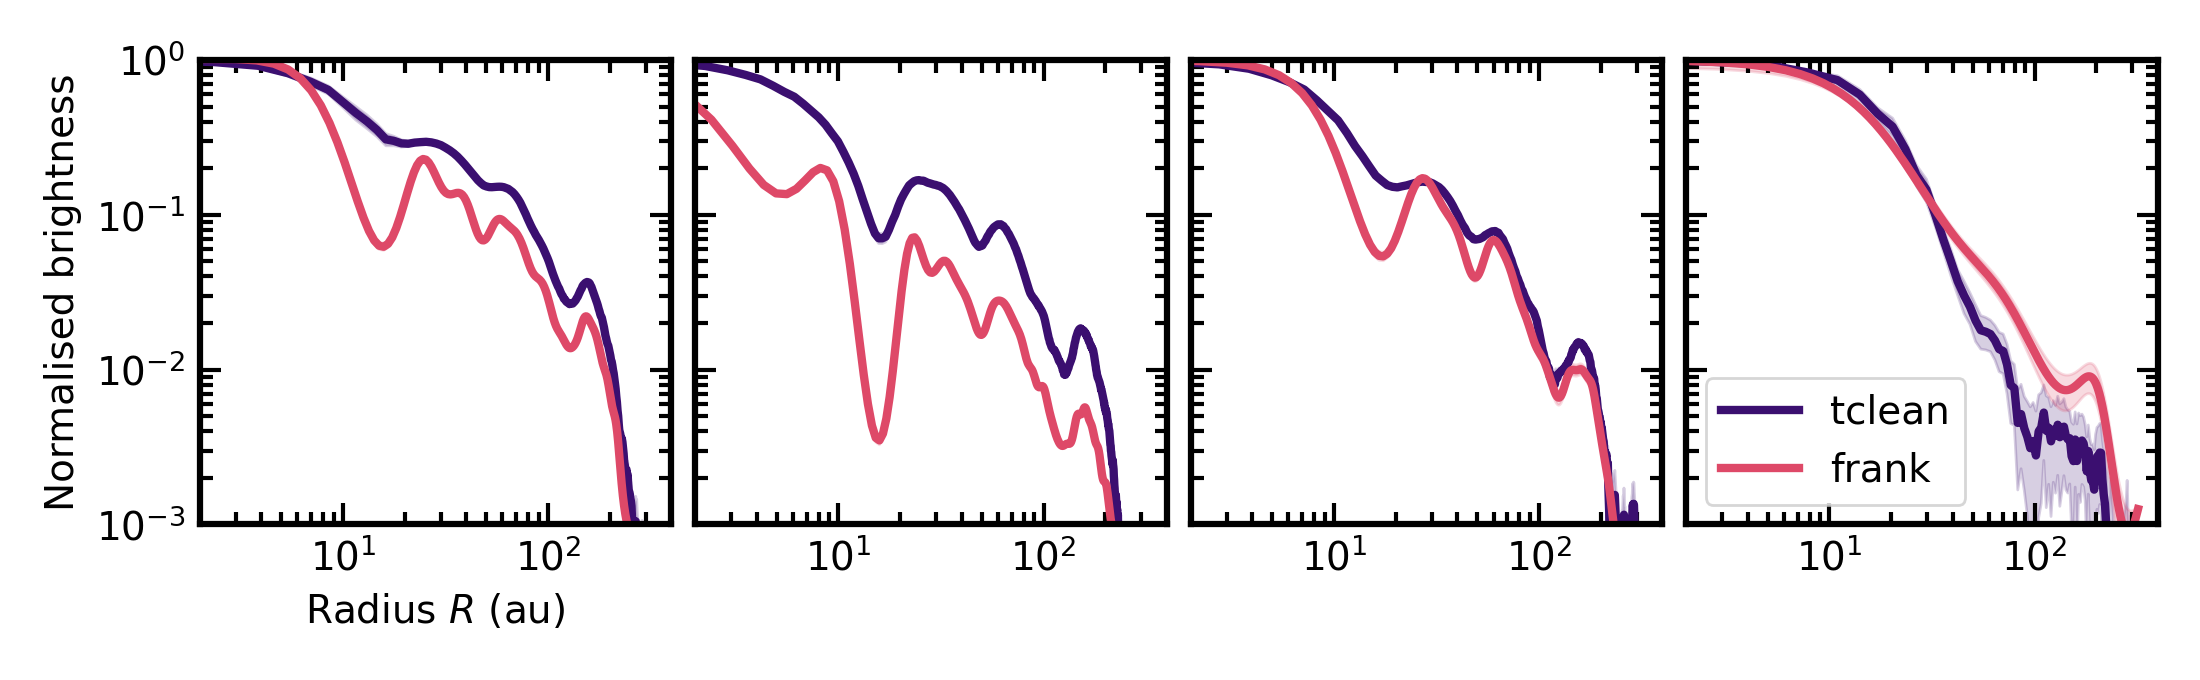

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [10]:
frankfits = [
    '../CI_Tau_frank_fits/statwt/band7/CI_Tau_B7_frank_profile_bestfit.dat',
    '../CI_Tau_frank_fits/statwt/band6/CI_Tau_B6_frank_profile_bestfit.dat',
    '../CI_Tau_frank_fits/statwt/band3_pssub/CI_Tau_B3_frank_profile_bestfit.dat',
    '../CI_Tau_frank_fits/statwt/bandKa_pssub/CI_Tau_Ka_frank_profile_bestfit.dat'
]

fig, axs = plt.subplots(1,4,figsize=(11.,3.4),sharex='all',sharey='row')

for idx in range(len(fitsfiles)):
    cube = imagecube(fitsfiles[idx], FOV=4.)

    #Radial profiles (tclean)
    x, y, dy = cube.radial_profile(inc=disc_inc, PA=disc_PA, dr=pixels[idx])
    x *= disc_dist
    
    #Keep these lines to convert emission to Jy/sr
    y_b  = _calculate_flux_jy_sr( y,cube.bmin,cube.bmaj) #in Jy/sr
    dy_b = _calculate_flux_jy_sr(dy,cube.bmin,cube.bmaj) #in Jy/sr
    
    l, = axs[idx].semilogy(x, y_b/y_b[0], lw=3., label='tclean', c=color_clean)
    axs[idx].fill_between(x, (y_b - dy_b)/y_b[0], (y_b + dy_b)/y_b[0], color=l.get_color(), alpha=0.2)
    
    #Radial profiles (frank)
    xf, yf, dy_f = np.loadtxt(frankfits[idx],unpack=True,skiprows=1)
    xf *= disc_dist

    l, = axs[idx].semilogx(xf, yf/yf[0], label='frank', lw=3., c=color_frank)
    axs[idx].fill_between(xf, (yf - dy_f)/yf[0], (yf + dy_f)/yf[0], color=l.get_color(), alpha=0.2)
    if idx == 3:
        axs[idx].legend(loc='lower left')

    axs[idx].set_xlim(2,400)
    axs[idx].set_ylim(1e-3,1)
    
axs[0].set_xlabel('Radius $R$ (au)')  
axs[0].set_ylabel('Normalised brightness')   

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

#plt.savefig('profiles_paper.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


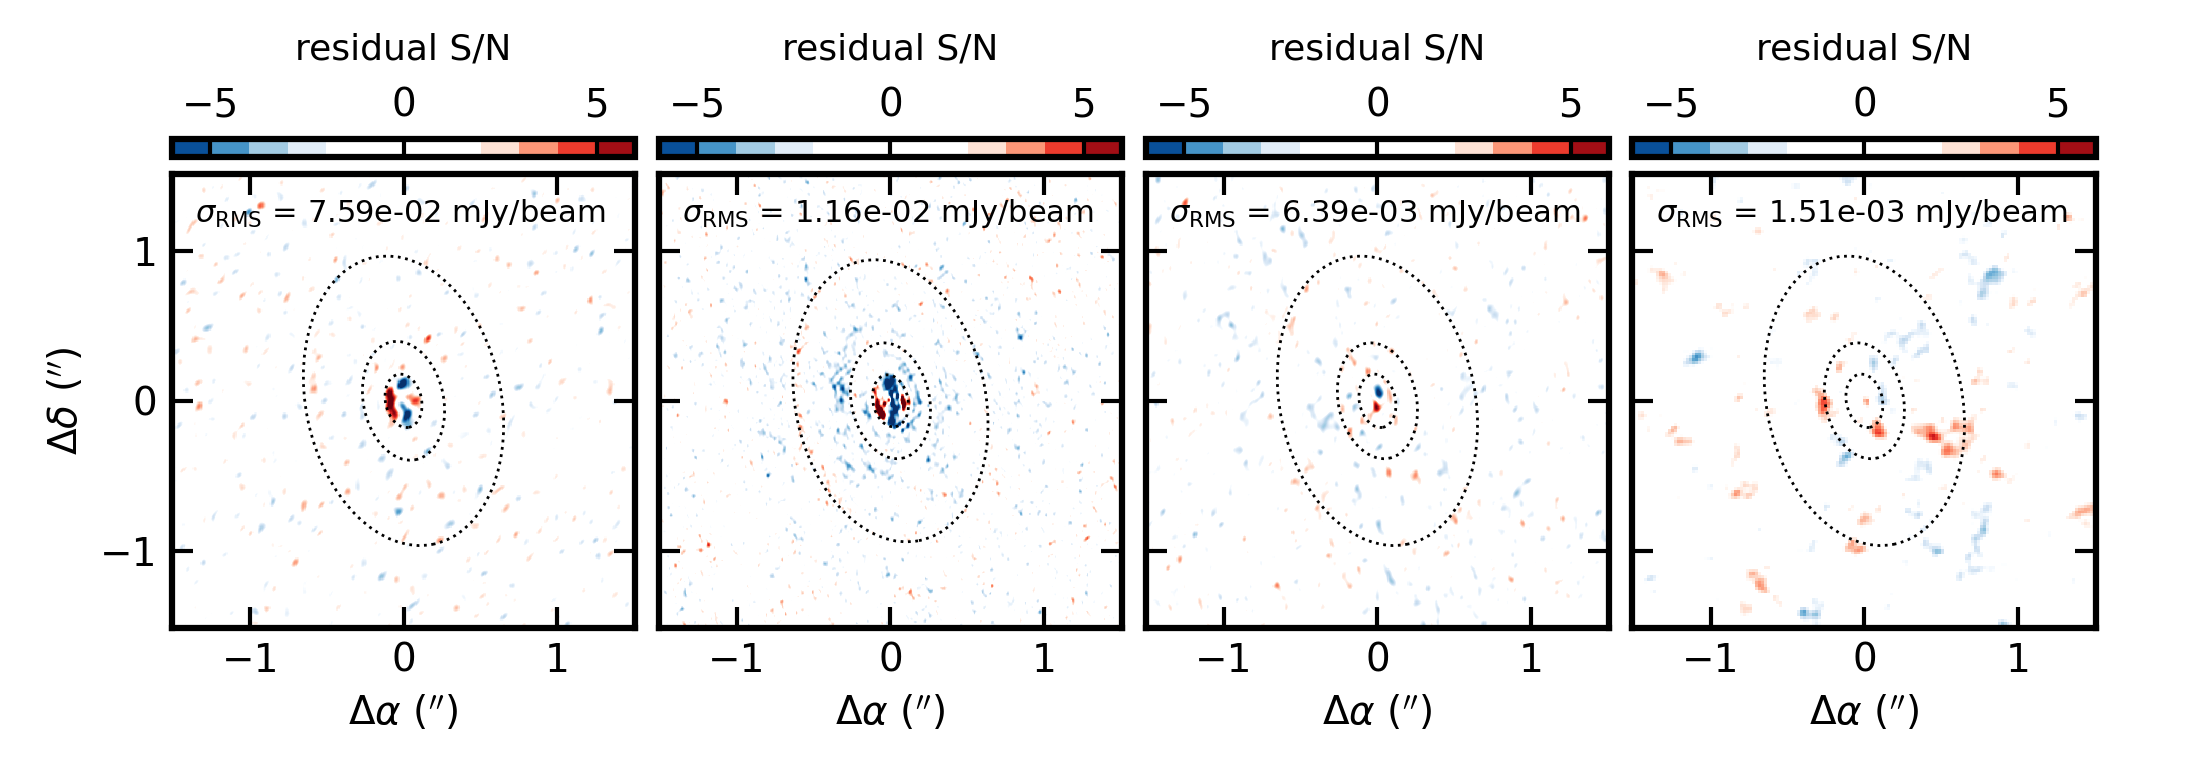

In [11]:
frankresiduals = [
    '../CI_Tau_frank_fits/residuals/band7/statwt/jeffscript/residuals_uvtable_-0.5robust.image.tt0.fits', 
    '../CI_Tau_frank_fits/residuals/band6/statwt/onechannel/jeffscript/residuals_uvtable_0.5robust.image.tt0.fits',
    '../CI_Tau_frank_fits/residuals/band3/statwt/onechannel/jeffscript/residuals_uvtable_0.5robust.image.tt0.fits',
    '../CI_Tau_frank_fits/residuals/bandKa/jeffscript/residuals_uvtable_1.5robust.image.tt0.fits'
]

noise = [7.59e-02,1.16e-02,6.39e-03,1.51e-03] #mJy/beam

limit = [6,6,6,6]
level = [5,5,5,5]

ring1 = [0.180,0.175,0.180,0.180]
ring2 = [0.400,0.390,0.390,0.390]
ring3 = [0.975,0.950,0.975,0.975]

fig, axs = plt.subplots(1,4,figsize=(11.,3.9),sharex='all',sharey='row')

for idx, _name in enumerate(frankresiduals):
    cube = imagecube(frankresiduals[idx], FOV=3., pixel_scale=pixels[idx])
    
    data = cube.data*1e3/noise[idx]
    lim  = max(np.amax(data),-np.amin(data))
    
    cmap = color_resid #plt.cm.get_cmap('coolwarm').copy()
    norm = colors.Normalize(vmin=-limit[idx], vmax=limit[idx])

    if idx != 3:
        p = axs[idx].pcolormesh(cube.xaxis, -cube.yaxis, data, cmap=cmap, norm=norm)
    else:
        p = axs[idx].pcolormesh(-cube.xaxis, cube.yaxis, data, cmap=cmap, norm=norm)
    p.set_rasterized(True)
    
    el = patches.Ellipse(xy=(-1.2,-1.2), width=cube.bmin, height=cube.bmaj, angle=cube.bpa, color='white', fill=False, hatch='/////', lw=2)
    axs[idx].add_patch(el)

    el_ring1 = patches.Ellipse(xy=(0,0), width=2*ring1[idx]*np.cos(np.deg2rad(49.24)), height=2*ring1[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx].add_patch(el_ring1)
    el_ring2 = patches.Ellipse(xy=(0,0), width=2*ring2[idx]*np.cos(np.deg2rad(49.24)), height=2*ring2[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx].add_patch(el_ring2)
    el_ring3 = patches.Ellipse(xy=(0,0), width=2*ring3[idx]*np.cos(np.deg2rad(49.24)), height=2*ring3[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx].add_patch(el_ring3)
    
    bar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax = axs[idx], ticks=[-level[idx],0,level[idx]],
        orientation = 'horizontal', location = 'top',
        aspect = 25, pad = 0.03,
        boundaries = np.linspace(-limit[idx], limit[idx], 2*limit[idx] + 1)
    )
    bar.ax.yaxis.set_tick_params(color='k', which='both') 
    bar.ax.xaxis.set_tick_params(color='k', which='both')
    bar.set_label(r'residual S/N', labelpad=10, fontsize=13)
    bar.solids.set_rasterized(True)

    axs[idx].text(
        0.05, 0.95, r'$\sigma_{\rm RMS}$ = '+f'{noise[idx]:2.2e} mJy/beam',
        ha = 'left', va = 'top', transform = axs[idx].transAxes, 
        #bbox = dict(boxstyle="round", ec="w", fc="k"),
        color = 'k', fontsize = 11,
    )
    
    axs[idx].set_xlabel(r"$\Delta\alpha\ ('')$")

axs[0].set_ylabel(r"$\Delta\delta\ ('')$")

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig('frank_residuals.pdf', bbox_inches='tight')
plt.show()

Summary plot disc_PAper:

In [12]:
def dist_au(x):
    """ Conversion from arcsec to au. """
    return x*disc_dist

In [13]:
def dist_arcsec(x):
    """ Conversion from au to arcsec. """
    return x*disc_dist**-1

In [14]:
def gaussian(x,mean,sigma):
    """ Gaussian function with prescribed mean (mean) and standard deviation (sigma). """
    return np.exp(-0.5*(x - mean)**2/sigma**2)

In [15]:
def gapringlabels(axs,idx):
    dark1     = [0.10,0.10, 0.11 ]
    dark1_min = [0.07,0.030,0.020]
    dark1_max = [8.00,3.000,5.000]

    dark2     = [0.30,0.30, 0.30 ]
    dark2_min = [0.05,0.035,0.020]
    dark2_max = [4.00,2.500,2.250]

    dark3     = [0.80,0.80, 0.73 ]
    dark3_min = [0.06,0.027,0.015]
    dark3_max = [0.70,0.400,0.300]

    bright1     = [0.180,0.180,0.180]
    bright1_max = [8.00, 7.800,5.000]
    bright1_min = [0.30, 0.200,0.095]

    bright2     = [0.390,0.390,0.390]
    bright2_max = [4.00, 4.000,2.700]
    bright2_min = [0.20, 0.150,0.100]

    bright3     = [0.975,0.950,0.975]
    bright3_max = [0.95, 0.900,0.500]
    bright3_min = [0.05, 0.035,0.015]

    shoulder     = [0.6 , 0.6,  0.6  ]
    shoulder_max = [1.65, 1,    0.78 ]
    shoulder_min = [0.1 , 0.05, 0.02 ]
 
    axs_plot.vlines(dark1[idx]*disc_dist,dark1_min[idx],dark1_max[idx],ls='-.',color='gray',lw=1.)
    axs_plot.text(dark1[idx]*disc_dist,dark1_min[idx],f'D{dark1[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='gray')
    
    axs_plot.vlines(dark2[idx]*disc_dist,dark2_min[idx],dark2_max[idx],ls='-.',color='gray',lw=1.)
    axs_plot.text(dark2[idx]*disc_dist,dark2_min[idx],f'D{dark2[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='gray')
    
    axs_plot.vlines(dark3[idx]*disc_dist,dark3_min[idx],dark3_max[idx],ls='-.',color='gray',lw=1.)
    axs_plot.text(dark3[idx]*disc_dist,dark3_min[idx],f'D{dark3[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='gray')

    axs_plot.vlines(bright1[idx]*disc_dist,bright1_min[idx],bright1_max[idx],ls='-.',color='k',lw=1.) 
    axs_plot.text(bright1[idx]*disc_dist,bright1_min[idx],f'B{bright1[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='k')
    
    axs_plot.vlines(bright2[idx]*disc_dist,bright2_min[idx],bright2_max[idx],ls='-.',color='k',lw=1.) 
    axs_plot.text(bright2[idx]*disc_dist,bright2_min[idx],f'B{bright2[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='k')
    
    axs_plot.vlines(bright3[idx]*disc_dist,bright3_min[idx],bright3_max[idx],ls='-.',color='k',lw=1.)
    axs_plot.text(bright3[idx]*disc_dist,bright3_min[idx],f'B{bright3[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='k')

    axs_plot.vlines(shoulder[idx]*disc_dist,shoulder_min[idx],shoulder_max[idx],ls='-.',color='k',lw=1.)
    axs_plot.text(shoulder[idx]*disc_dist,shoulder_min[idx],f'B{shoulder[idx]*disc_dist:1.0f}',fontsize=10,rotation=270,color='k')

<IPython.core.display.Javascript object>


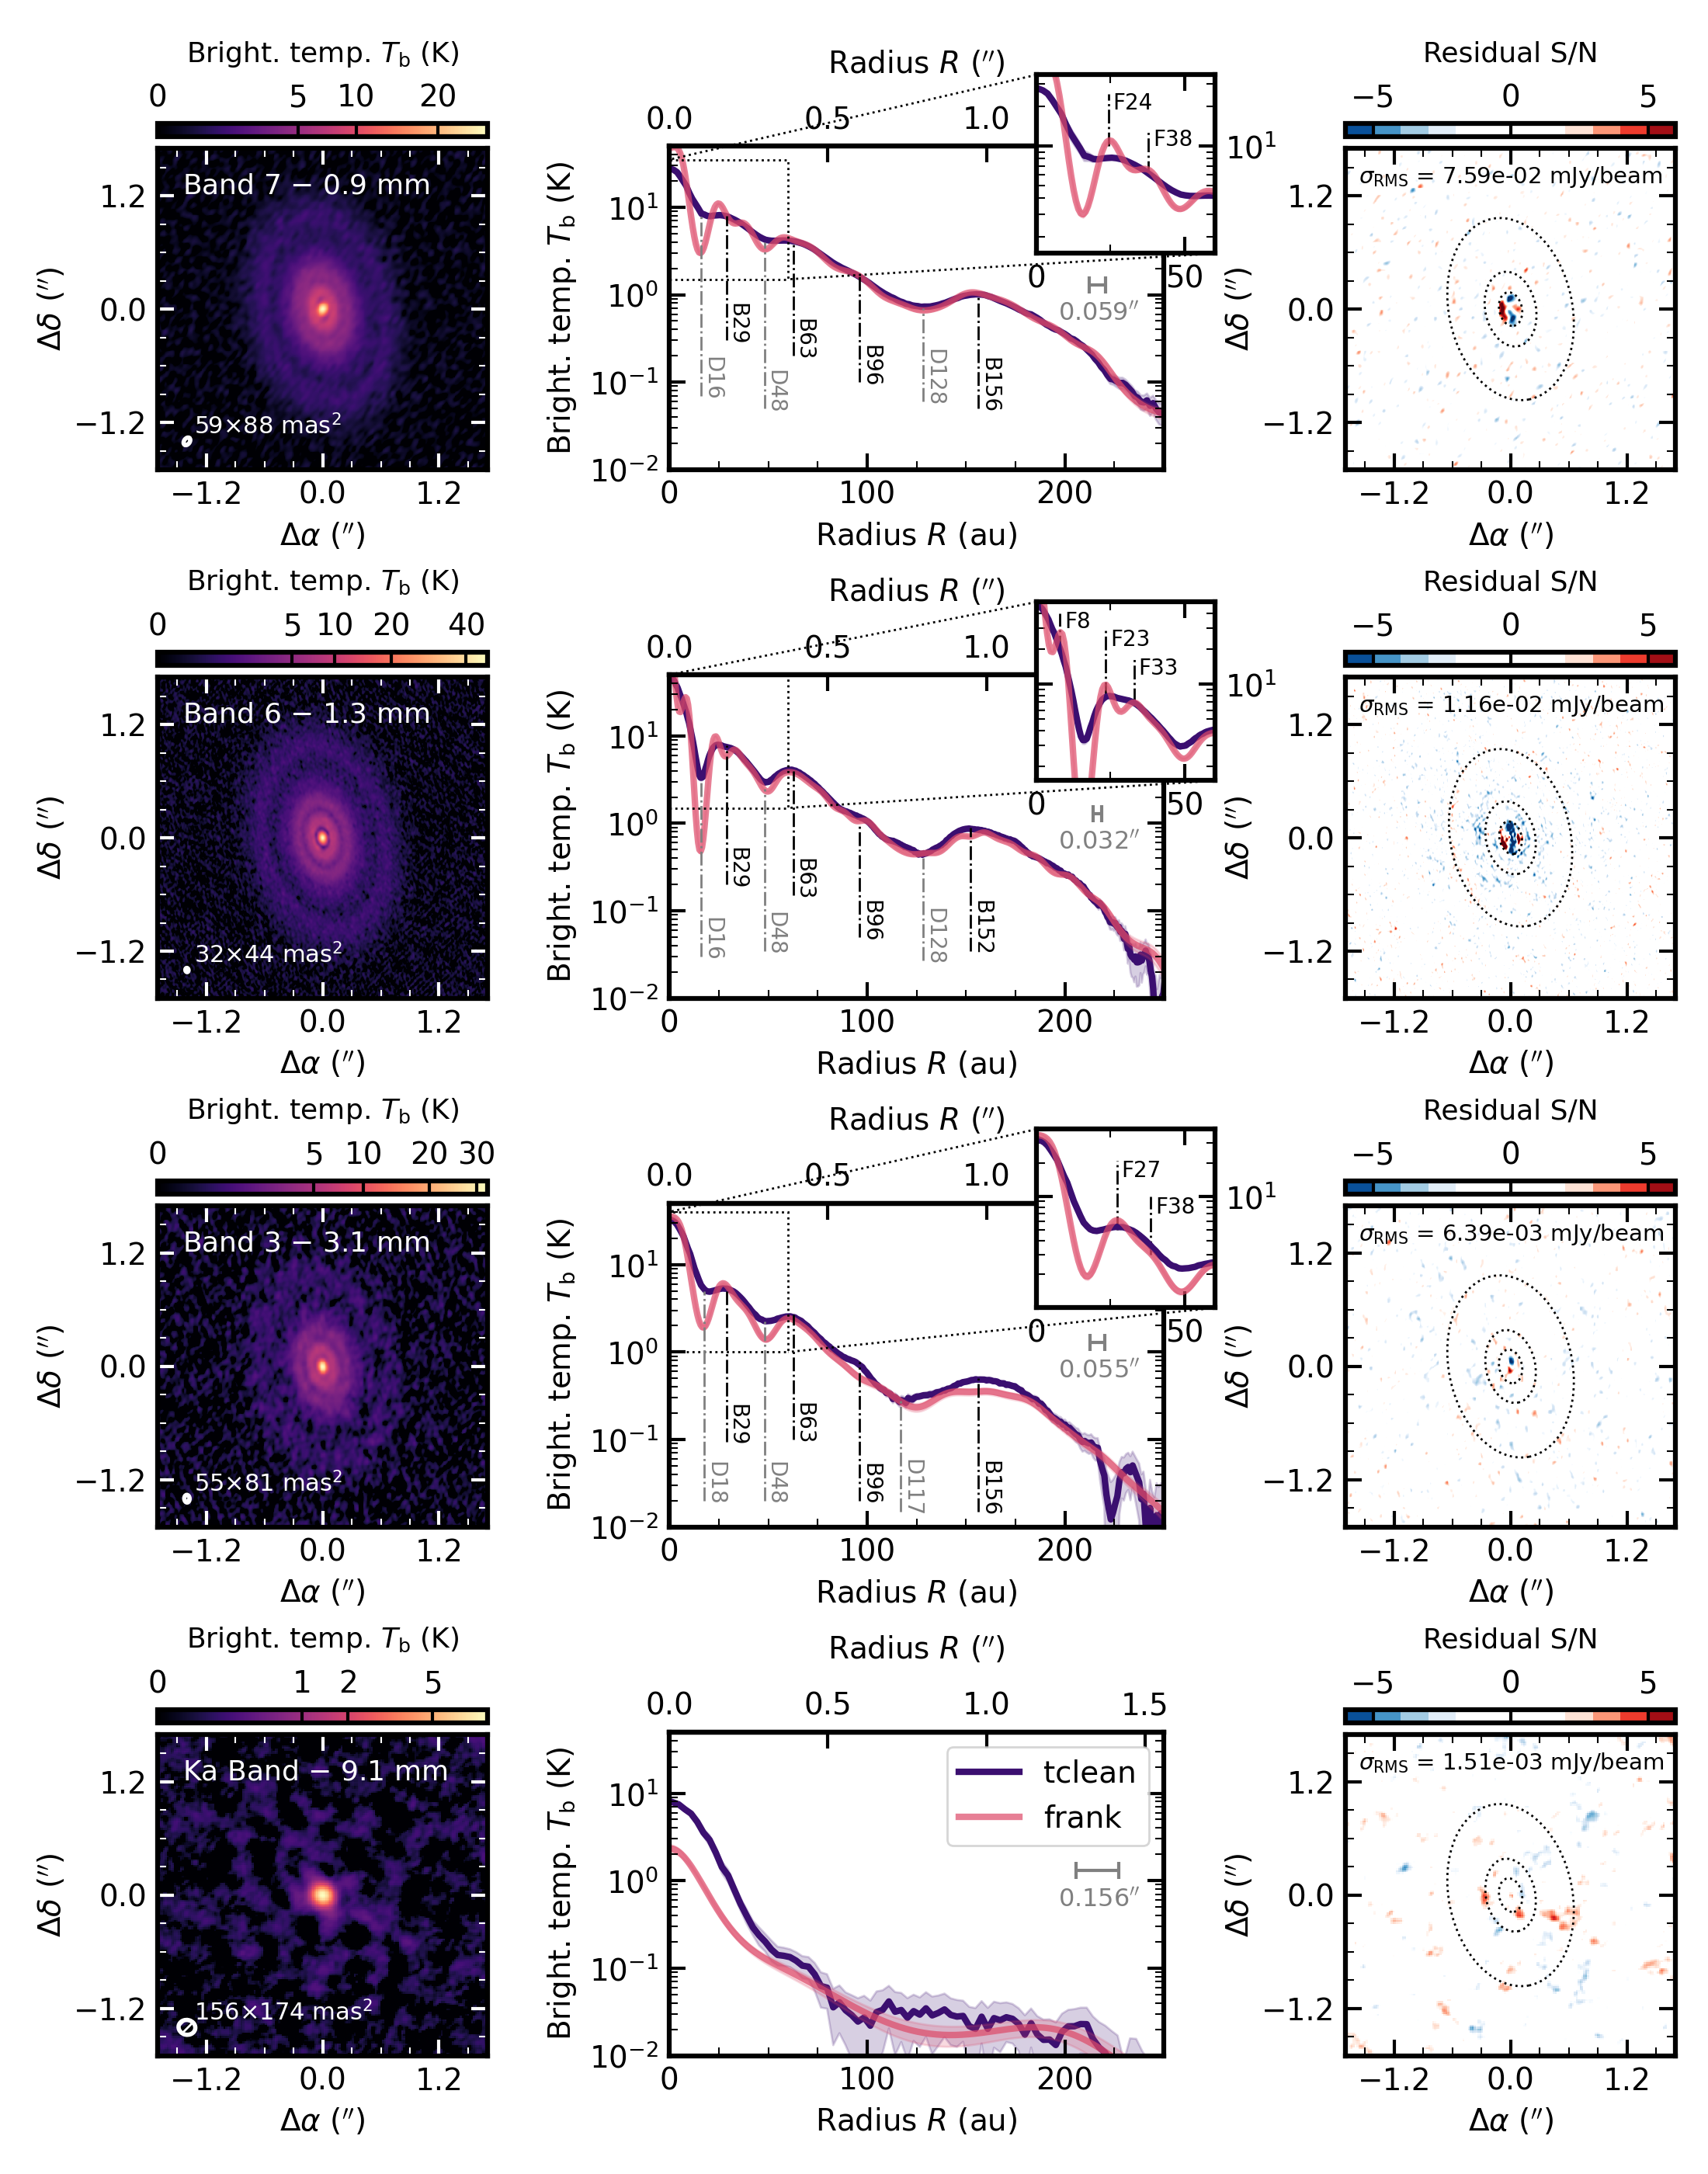

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.
	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [16]:
fig, axs = plt.subplots(4,3,figsize=(11.,14.),gridspec_kw={"width_ratios":[1.,1.5,1.]})

for idx in range(len(fitsfiles)):

    #Left column: plot 2D maps
    cube = imagecube(fitsfiles[idx], FOV=4.5, pixel_scale=pixels[idx])
    
    data = cube.data
    data = cube.jybeam_to_Tb_RJ(data)

    #Define colormap and normalisation
    cmap = plt.cm.get_cmap('magma').copy()
    norm = colors.PowerNorm(pov[idx], vmin=0., vmax=np.amax(data))

    #Plot intensity map
    if idx != 3:
        p = axs[idx,0].pcolormesh(cube.xaxis, -cube.yaxis, data, cmap=cmap, norm=norm)
    else:
        p = axs[idx,0].pcolormesh(-cube.xaxis, cube.yaxis, data, cmap=cmap, norm=norm)
    p.set_rasterized(True)
    axs[idx,0].xaxis.set_tick_params(color='white', which='both') 
    axs[idx,0].yaxis.set_tick_params(color='white', which='both') 

    #Plot the beam shape and annotate its size
    el = patches.Ellipse(xy=(-1.4,-1.4), width=cube.bmin, height=cube.bmaj, angle=cube.bpa, color='white', fill=False, hatch='/////', lw=2)
    axs[idx,0].add_patch(el)
    axs[idx,0].text(
        -1.325, -1.325, f'{1e3*cube.bmin:2.0f}'+r'$\times$'+f'{1e3*cube.bmaj:2.0f}'+' mas$^2$', color='w', fontsize=11)

    #Colorbar
    bar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax = axs[idx,0], ticks=ticks[idx],
        orientation = 'horizontal', location = 'top',
        aspect = 25, pad = 0.03,
    )
    bar.ax.yaxis.set_tick_params(color='k', which='both', length=5.) 
    bar.ax.xaxis.set_tick_params(color='k', which='both', length=5.)
    #if idx == 0:
    bar.set_label(r'Bright. temp. $T_{\rm b}$ (K)', labelpad=10, fontsize=13)
    bar.solids.set_rasterized(True)
    
    #Annotate the emission wavelength
    axs[idx,0].text(
        0.075, 0.925, r'{}'.format(lbl[idx]),   
        ha = 'left', va = 'top', transform = axs[idx,0].transAxes, 
        #bbox = dict(boxstyle="round", ec="w", fc="k"),
        color = 'white', fontsize = 13,
    )
    
    #Limits
    axs[idx,0].set_ylim(-1.7,1.7)
    axs[idx,0].set_xlim(-1.7,1.7)
    axs[idx,0].xaxis.set_ticks([-1.2,0.,1.2])
    axs[idx,0].yaxis.set_ticks([-1.2,0.,1.2])
    
    axs[idx,0].xaxis.set_minor_locator(MultipleLocator(0.3))
    axs[idx,0].yaxis.set_minor_locator(MultipleLocator(0.3))
    axs[idx,0].tick_params(which='minor', color='w', length=4., width=0.75)
        
    axs[idx,0].set_ylabel(r"$\Delta\delta\ ('')$", labelpad=3)
    #if idx == 3:
    axs[idx,0].set_xlabel(r"$\Delta\alpha\ ('')$")
    
    #Right column: plot 2D frank residuals
    cube_residuals = imagecube(frankresiduals[idx], FOV=4.5, pixel_scale=pixels[idx])
    
    data = cube_residuals.data*1e3/noise[idx]
    lim  = max(np.amax(data),-np.amin(data))
    
    #Define colormap and normalisation
    cmap = color_resid #plt.cm.get_cmap('coolwarm').copy()
    norm = colors.Normalize(vmin=-limit[idx], vmax=limit[idx])

    #Plot intensity map
    if idx != 3:
        p = axs[idx,2].pcolormesh(cube_residuals.xaxis, -cube_residuals.yaxis, data, cmap=cmap, norm=norm)
    else:
        p = axs[idx,2].pcolormesh(-cube_residuals.xaxis, cube_residuals.yaxis, data, cmap=cmap, norm=norm)
    p.set_rasterized(True)
    
    # el = patches.Ellipse(xy=(-1.2,-1.2), width=cube.bmin, height=cube.bmaj, angle=cube.bpa, color='white', fill=False, hatch='/////', lw=2)
    # axs[idx,2].add_patch(el)

    #Plot the ring location
    el_ring1 = patches.Ellipse(xy=(0,0), width=2*ring1[idx]*np.cos(np.deg2rad(49.24)), height=2*ring1[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx,2].add_patch(el_ring1)
    el_ring2 = patches.Ellipse(xy=(0,0), width=2*ring2[idx]*np.cos(np.deg2rad(49.24)), height=2*ring2[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx,2].add_patch(el_ring2)
    el_ring3 = patches.Ellipse(xy=(0,0), width=2*ring3[idx]*np.cos(np.deg2rad(49.24)), height=2*ring3[idx], angle=11.28, color='k', fill=False, ls=':')
    axs[idx,2].add_patch(el_ring3)
    
    #Colorbar
    bar = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax = axs[idx,2], ticks=[-level[idx],0,level[idx]],
        orientation = 'horizontal', location = 'top',
        aspect = 25, pad = 0.03,
        boundaries = np.linspace(-limit[idx], limit[idx], 2*limit[idx] + 1)
    )
    bar.ax.yaxis.set_tick_params(color='k', which='both', length=5.) 
    bar.ax.xaxis.set_tick_params(color='k', which='both', length=5.)
    #if idx == 0:
    bar.set_label(r'Residual S/N', labelpad=10, fontsize=13)
    bar.solids.set_rasterized(True)

    #Annotate the RMS noise
    axs[idx,2].text(
        0.04, 0.95, r'$\sigma_{\rm RMS}$ = '+f'{noise[idx]:2.2e} mJy/beam',
        ha = 'left', va = 'top', transform = axs[idx,2].transAxes, 
        #bbox = dict(boxstyle="round", ec="w", fc="k"),
        color = 'k', fontsize = 10.5,
    )
    
    #Limits
    axs[idx,2].set_ylim(-1.7,1.7)
    axs[idx,2].set_xlim(-1.7,1.7)
    axs[idx,2].xaxis.set_ticks([-1.2,0.,1.2])
    axs[idx,2].yaxis.set_ticks([-1.2,0.,1.2])
    
    axs[idx,2].xaxis.set_minor_locator(MultipleLocator(0.3))
    axs[idx,2].yaxis.set_minor_locator(MultipleLocator(0.3))
    axs[idx,2].tick_params(which='minor', color='k', length=4., width=0.75)
    
    axs[idx,2].set_ylabel(r"$\Delta\delta\ ('')$", labelpad=3)
    #if idx == 3:
    axs[idx,2].set_xlabel(r"$\Delta\alpha\ ('')$")
        
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)
    
for idx in range(len(fitsfiles)):
    #Import fitsfile
    cube = imagecube(fitsfiles[idx], FOV=4.5)
    
    #Central colum: plot 1D radial profiles from tclean and frank
    #Create new subplot:
    centre   = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=axs[idx,1],wspace=0.1,hspace=0.2,height_ratios=[0.1,1])
    axs_plot = plt.subplot(centre[1])
    
    #Init tclean radial profiles in Jy/beam
    x, y, dy = cube.radial_profile(inc=disc_inc, PA=disc_PA, dr=pixels[idx])
    x *= disc_dist#radius in *au*
    
    #Convert to brightness temperature and plot
    y_b  = cube.jybeam_to_Tb_RJ(y)
    dy_b = cube.jybeam_to_Tb_RJ(dy)
    
    l, = axs_plot.semilogy(x, y_b, lw=3., label='tclean', c=color_clean, zorder=-10)
    axs_plot.fill_between(x, y_b - dy_b, y_b + dy_b, color=l.get_color(), alpha=0.2, zorder=-10)
      
    axs_plot.xaxis.set_ticks([0,100,200])
    axs_plot.xaxis.set_minor_locator(MultipleLocator(25))
    axs_plot.tick_params(which='minor', color='k', length=4., width=0.75)
    axs_plot.tick_params(axis='x',which='both',top=False,labeltop=False)
    
    axs_plot.set_yticks([1e-2,1e-1,1e0,1e1])
    axs_plot.set_yticklabels((r'$10^{-2}$','0.1','1','10'))
    
    axs_plot.set_ylim(1e-2,5e+1)
    axs_plot.set_xlim(0,250)
    
    # Build secondary axes to show radius in arcsec
    secax = axs_plot.secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    secax.set_xlabel("Radius $R\ ('')$", labelpad=15)#, labelpad=20)
    
    axs_plot.set_ylabel(r'Bright. temp. $T_{\rm b}$ (K)')
    
    #Show gap/ring labels
    if idx < 3:
        gapringlabels(axs_plot,idx)
    
    #Init frank radial profiles in Jy/sr
    xf, yf, dyf = np.loadtxt(frankfits[idx], unpack=True, skiprows=1)
    xf *= disc_dist
    
    #Convert to brightness temperature and plot
    yf_b  = _jysr_to_tb(yf,freq[idx])
    dyf_b = _jysr_to_tb(dyf,freq[idx])

    if idx < 2:
        l, = axs_plot.semilogy(xf, yf_b, lw=3., c=color_frank, zorder=-10, alpha=0.7)
        axs_plot.fill_between(xf, (yf_b - dyf_b), (yf_b + dyf_b), color=l.get_color(), alpha=0.2)    
    elif idx == 2:
        l, = axs_plot.semilogy(xf, yf_b, lw=3., c=color_frank, zorder=-10, alpha=0.7)
        axs_plot.fill_between(xf, (yf_b - dyf_b), (yf_b + dyf_b), color=l.get_color(), alpha=0.2)    
    else:
        l, = axs_plot.semilogy(xf, yf_b, lw=3., c=color_frank, zorder=-10, alpha=0.7, label='frank')
        axs_plot.fill_between(xf, yf_b - dyf_b, yf_b + dyf_b, color=l.get_color(), alpha=0.2)
        
    axs_plot.set_xlabel(r'Radius $R$ (au)')
    if idx == 3:
        axs_plot.legend()
        
    if idx == 0:
        # axin = zoomed_inset_axes(axs_plot, zoom=1.5, bbox_to_anchor=[0.62,0.8730,0.1,0.1], bbox_transform=axs_plot.figure.transFigure)
        
        axin = inset_axes(
            axs_plot, 
            width          = 1.15,
            height         = 1.15,
            loc            = 'upper right',
            bbox_to_anchor = [0.62,0.8725,0.1,0.1], 
            bbox_transform = axs_plot.figure.transFigure
        )

        mark_inset(axs_plot, axin, loc1=2, loc2=4, ls=':', ec='k')
        
        axin.semilogy(x, y_b, lw=3., c=color_clean)
        axin.fill_between(x, y_b - dy_b, y_b + dy_b, color=color_clean, alpha=0.2)
        
        axin.semilogy(xf, yf_b, lw=3., c=color_frank, alpha=0.7)
        axin.fill_between(xf, (yf_b - dyf_b), (yf_b + dyf_b), color=color_frank, alpha=0.2)
        
        axin.set_xlim(0,60)
        axin.set_ylim(1.5,35)
        
        axin.xaxis.set_minor_locator(MultipleLocator(25))
        axin.tick_params(which='minor', color='k', length=4., width=0.75)
    
        axin.yaxis.tick_right()
        axin.yaxis.set_ticks_position('both')
        
        axin.vlines(0.152*disc_dist,10.,25,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.161*disc_dist,19,f'F{0.152*disc_dist:1.0f}',fontsize=10,color='k')
        
        axin.vlines(0.235*disc_dist, 6.,13,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.245*disc_dist,10,f'F{0.235*disc_dist:1.0f}',fontsize=10,color='k')
        
    elif idx == 1:
        # axin = zoomed_inset_axes(axs_plot, zoom=1.5, bbox_to_anchor=[0.62,0.630,0.1,0.1], bbox_transform=axs_plot.figure.transFigure)
        
        axin = inset_axes(
            axs_plot, 
            width          = 1.15,
            height         = 1.15,
            loc            = 'upper right',
            bbox_to_anchor = [0.62,0.6300,0.1,0.1], 
            bbox_transform = axs_plot.figure.transFigure
        )

        mark_inset(axs_plot, axin, loc1=2, loc2=4, ls=':', ec='k')
        
        axin.semilogy(x, y_b, lw=3., c=color_clean)
        axin.fill_between(x, y_b - dy_b, y_b + dy_b, color=color_clean, alpha=0.2)
        
        axin.semilogy(xf, yf_b, lw=3., c=color_frank, alpha=0.7)
        axin.fill_between(xf, (yf_b - dyf_b), (yf_b + dyf_b), color=color_frank, alpha=0.2)
        
        axin.set_xlim(0,60)
        axin.set_ylim(1.5,50)
        
        axin.xaxis.set_minor_locator(MultipleLocator(25))
        axin.tick_params(which='minor', color='k', length=4., width=0.75)
    
        axin.yaxis.tick_right()
        axin.yaxis.set_ticks_position('both')
        
        axin.vlines(0.050*disc_dist,20.,40,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.060*disc_dist,30,f'F{0.050*disc_dist:1.0f}',fontsize=10,color='k')
        
        axin.vlines(0.145*disc_dist,8.0,30,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.155*disc_dist,21,f'F{0.145*disc_dist:1.0f}',fontsize=10,color='k')
        
        axin.vlines(0.205*disc_dist,7.0,17,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.215*disc_dist,12,f'F{0.205*disc_dist:1.0f}',fontsize=10,color='k')
        
    elif idx == 2:
        # axin = zoomed_inset_axes(axs_plot, zoom=1.5, bbox_to_anchor=[0.62,0.3875,0.1,0.1],bbox_transform=axs_plot.figure.transFigure)
        
        axin = inset_axes(
            axs_plot, 
            width          = 1.15,
            height         = 1.15,
            loc            = 'upper right',
            bbox_to_anchor = [0.62,0.3875,0.1,0.1], 
            bbox_transform = axs_plot.figure.transFigure
        )

        mark_inset(axs_plot, axin, loc1=2, loc2=4, ls=':', ec='k')
        
        axin.semilogy(x, y_b, lw=3., c=color_clean)
        axin.fill_between(x, y_b - dy_b, y_b + dy_b, color=color_clean, alpha=0.2)
        
        axin.semilogy(xf, yf_b, lw=3., c=color_frank, alpha=0.7)
        axin.fill_between(xf, (yf_b - dyf_b), (yf_b + dyf_b), color=color_frank, alpha=0.2)
        
        axin.set_xlim(0,60)
        axin.set_ylim(1,40)
        
        axin.xaxis.set_minor_locator(MultipleLocator(25))
        axin.tick_params(which='minor', color='k', length=4., width=0.75)
    
        axin.set_yticks([1e1])
        axin.yaxis.tick_right()
        axin.yaxis.set_ticks_position('both')
        
        axin.get_yaxis().get_major_formatter().labelOnlyBase = False
        
        axin.vlines(0.170*disc_dist,5.0,21,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.178*disc_dist,15,f'F{0.17*disc_dist:1.0f}',fontsize=10,color='k')
        
        axin.vlines(0.240*disc_dist,3.0,10,ls='-.',color='k',lw=1., zorder=-3) 
        axin.text(0.250*disc_dist, 7,f'F{0.24*disc_dist:1.0f}',fontsize=10,color='k')

    #artist = mpatches.FancyBboxPatch((1.6*disc_dist, 0.03), 0.3*disc_dist, 0.07, lw=1, fc='white', ec='k', boxstyle=mpatches.BoxStyle("Round", pad=0.02*disc_dist), zorder=10)
    #axs_plot.add_artist(artist)
    #if idx == 3:
        ##z = np.linspace(1.2,1.5,200)*disc_dist
        ##axs_plot.plot(z,0.20*gaussian(z,mean=1.35*disc_dist,sigma=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2)))) + 7.00e-2,lw=2,c='gray')
    #    axs_plot.errorbar(
    #        1.35*disc_dist,1.25e-1,xerr=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2))),
    #        ls='none',lw=1.5,c='gray',capsize=4,capthick=1.5
    #    ) 
    #    axs_plot.text(
    #        1.225*disc_dist,5.0e-2,f'{cube.bmin:0.3f}' + "$''$",c='gray',fontsize=11.5,
    #    )
        
    #elif idx == 2:
        ##z = np.linspace(1.25,1.45,200)*disc_dist
        ##axs_plot.plot(z,1.00*gaussian(z,mean=1.35*disc_dist,sigma=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2)))) + 5.00e-1,lw=2,c='gray')
    #    axs_plot.errorbar(
    #        1.35*disc_dist,6.25e-1,xerr=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2))),
    #        ls='none',lw=1.5,c='gray',capsize=4,capthick=1.5
    #    )
    #    axs_plot.text(
    #        1.225*disc_dist,2.5e-1,f'{cube.bmin:0.3f}' + "$''$",c='gray',fontsize=11.5,
    #    )
        
    ##elif idx == 1:
    #else:
        ##z = np.linspace(1.275,1.425,200)*disc_dist
        ##axs_plot.plot(z,1.00*gaussian(z,mean=1.35*disc_dist,sigma=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2)))) + 6.50e-1,lw=2,c='gray')
    axs_plot.errorbar(
        1.35*disc_dist,1.30e-0,xerr=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2))),
        ls='none',lw=1.5,c='gray',capsize=4,capthick=1.5
    )
        ##axs_plot.text(
        ##    1.225*disc_dist,3.2e-1,f'{cube.bmin:0.3f}' + "$''$",c='gray',fontsize=11.5,
        ##)
    axs_plot.text(
        1.225*disc_dist,5.0e-1,f'{cube.bmin:0.3f}' + "$''$",c='gray',fontsize=11.5,
    )
    ##else:
    ##    z = np.linspace(1.25,1.45,200)*disc_dist
    ##    axs_plot.plot(z,0.05*gaussian(z,mean=1.35*disc_dist,sigma=cube.bmin*disc_dist/(2*np.sqrt(2*np.log(2)))) + 3.25e-2,lw=2,c='gray')
    ##    axs_plot.text(
    ##        1.225*disc_dist,1.6e-2,f'{cube.bmin:0.3f}' + "$''$",c='gray',fontsize=11.5
    ##    )
          
plt.savefig('image_montage.pdf',bbox_inches='tight')
plt.show()